## Testing File For the Best Model From the DB2 Data Cleaning
In this notebook the test experiments are imported, use the best model from the training, and evaluated.

### 1- Test Data Loading and Concatenation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import dalex as dx
import matplotlib.pyplot as plt
import yaml
import requests

Declairing all the tables that we use in the experiemtns.

In [2]:
tables = {
    'Table name': ["LINEITEM1", "GIGANTICORDERS", "ORDERS2", "ORDERS3", "ORDERS4", "ORDERS5", "ORDERS6", "ORDERS7", "ORDERS8", "ORDERS10", "ORDERSWIDE2"],
    'Data size(MB)': [674, 5477, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 275, 5337],
    'number of rows': [3894493, 45000000, 15000000, 15000000, 15000000, 15000000, 15000000, 15000000,  15000000, 1993416, 15000000],
    'number of columns': [16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27]
    }

tables_df = pd.DataFrame(tables)
tables_df.head()

,Table name,Data size(MB),number of rows,number of columns
0,LINEITEM1,674,3894493,16
1,GIGANTICORDERS,5477,45000000,9
2,ORDERS2,1825,15000000,9
3,ORDERS3,1825,15000000,9
4,ORDERS4,1825,15000000,9


The allocated system configuration 

In [3]:
source_machine_specs = {
    'RAM (GB)': [120],
    'CPU': [16],
    'Disk (GB)': [20],
    'External Disk (GB)': [576]
    }

source_machine_df = pd.DataFrame(source_machine_specs)
source_machine_df.head()

,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,120,16,20,576


In [4]:
# Function to extract numeric part from RAM string (e.g. "10g" -> 10)
def extract_ram_value(ram_str):
    return float(''.join(filter(str.isdigit, ram_str)))

### Extracting Resource Usage for each Experiment
Importing test experiments resource usages (CPU, RAM) from the YML files (For now: using `docker-compose.yml` of the experiments)

In [5]:
# Function to return the DataFrame of CPU and RAM usage for each experiment based on the provided URLs
def urls_dataframe(urls):
    """
    Generates a DataFrame containing CPU and RAM usage for each experiment based on YAML configurations.

    Parameters:
        urls (list of str): List of URLs pointing to YAML configuration files.

    Returns:
        DataFrame: A DataFrame with columns 'CPU' and 'RAM (GB)' containing system specifications
                   for the provided experiments.

    Notes:
        - CPU usage is normalized against the source machine's total CPU capacity.
        - RAM usage is extracted from YAML memory limits or defaults to the source machine's RAM if not specified.
    """
    parsed_yaml_data = []

    for url in urls:
        try:
            response = requests.get(url)
            if response.status_code == 200:
                yaml_content = yaml.safe_load(response.text)
                if 'deploy' in yaml_content['services']['web'] and 'resources' in yaml_content['services']['web']['deploy']:
                    cpus = yaml_content['services']['web']['deploy']['resources']['limits'].get('cpus', source_machine_df["CPU"].values[0])
                    cpus = float(cpus) / source_machine_df["CPU"].values[0]
                    ram = yaml_content['services']['web']['deploy']['resources']['limits'].get('memory', f'{source_machine_df["RAM (GB)"].values[0]}g')
                    ram_value = extract_ram_value(ram)
                else:
                    cpus = source_machine_df["CPU"].values[0]
                    ram_value = source_machine_df["RAM (GB)"].values[0]

                parsed_yaml_data.append({'CPU': cpus, 'RAM (GB)': ram_value})
            else:
                print(f"Failed to fetch {url}. Status code: {response.status_code}")
        except Exception as e:
            print(f"Error while fetching {url}: {e}")

    urls_df = pd.DataFrame(parsed_yaml_data)
    return urls_df


In [6]:
# test_urls = [
#     "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp56/docker-compose.yml",
#     "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp57/docker-compose.yml",
#     "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp58/docker-compose.yml",
#     "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp59/docker-compose.yml",
#     "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp60/docker-compose.yml"
# ]

test_urls = [
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp81/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp82/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp83/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp84/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp85/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp86/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp87/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp88/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp89/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp90/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp91/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp92/engine-docker-compose.yml", 
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp72/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp73/engine-docker-compose.yml"
]

test_system_specs_df = urls_dataframe(test_urls)
test_system_specs_df

,CPU,RAM (GB)
0,16,120
1,16,120
2,16,120
3,16,120
4,16,120
5,16,120
6,16,120
7,16,120
8,16,120
9,16,120


In [7]:
# Another Test set
test1_url = ["https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp56/docker-compose.yml",
             "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp65/docker-compose.yml"]

test1_system_specs_df = urls_dataframe(test1_url)
test1_system_specs_df

,CPU,RAM (GB)
0,0.6250,10.0
1,0.0625,10.0


### Loading Test Performance Benchmark Datasets

In [8]:
# Load test performance benchmark datasets
# v3_exp56_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp56/performanceBenchmark.csv')
# v3_exp57_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp57/performanceBenchmark.csv')
# v3_exp58_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp58/performanceBenchmark.csv')
# v3_exp59_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp59/performanceBenchmark.csv')
# v3_exp60_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp60/performanceBenchmark.csv')
# v3_exp65_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp65/performanceBenchmark.csv')


v5_exp81_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp81/performanceBenchmark.csv')
v5_exp82_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp82/performanceBenchmark.csv')
v5_exp83_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp83/performanceBenchmark.csv')
v5_exp84_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp84/performanceBenchmark.csv')
v5_exp85_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp85/performanceBenchmark.csv')
v5_exp86_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp86/performanceBenchmark.csv')
v5_exp87_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp87/performanceBenchmark.csv')
v5_exp88_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp88/performanceBenchmark.csv')
v5_exp89_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp89/performanceBenchmark.csv')
v5_exp90_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp90/performanceBenchmark.csv')
v5_exp91_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp91/performanceBenchmark.csv')
v5_exp92_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v5/exp92/performanceBenchmark.csv')

v4_exp72_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp72/performanceBenchmark.csv')
v4_exp73_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp73/performanceBenchmark.csv')

In [9]:
# print("Columns of the experiemtns: ")
# print(v3_exp56_performance_df.columns)

# print("\nFirst Five Rows of a Dataframe: ")
# v3_exp56_performance_df.head()

print("Columns of the experiemtns: ")
print(v5_exp81_performance_df.columns)

print("\nFirst Five Rows of a Dataframe: ")
v5_exp81_performance_df.head()

Columns of the experiemtns: 
Index(['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase',
       'tables', 'maxStreams', 'binary', 'attempt_number',
       'Experiment startTime', 'TotalExperimentTime', 'TotaltransferTime',
       'totalPrecheckTime', 'TotalClearTime', 'ExperimentStatus'],
      dtype='object')

First Five Rows of a Dataframe: 


,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus
0,1,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738671e+09,7724.177188,7595.90247,0.0,14.810558,True


In [10]:
# Concatenating the test experiments
# exp 56-60
test_performance_dfs = [v5_exp81_performance_df, v5_exp82_performance_df, v5_exp83_performance_df,
                        v5_exp84_performance_df, v5_exp85_performance_df, v5_exp86_performance_df,
                        v5_exp87_performance_df, v5_exp88_performance_df, v5_exp89_performance_df,
                        v5_exp90_performance_df, v5_exp91_performance_df, v5_exp92_performance_df,
                        v4_exp72_performance_df, v4_exp73_performance_df]

test_performance_df = pd.concat(test_performance_dfs, ignore_index=True)

# exp 56, 65
# test1_performance_dfs = [v3_exp56_performance_df, v3_exp65_performance_df]
# test1_performance_df = pd.concat(test1_performance_dfs, ignore_index=True)

In [11]:
# Function to combine the experimetns with their system configuration
def combine_experiment_data_with_config(test_performance_df, system_specs_df, disk_value, external_disk_value):
    """
    Combines experiment performance data with the corresponding system configuration.

    Parameters:
        test_performance_df (DataFrame): DataFrame containing experiment performance data.
        system_specs_df (DataFrame): DataFrame containing system configuration data derived from YAML files.
        disk_value (float): Value for the 'Disk (GB)' column to be added.
        external_disk_value (float): Value for the 'External Disk (GB)' column to be added.

    Returns:
        DataFrame: A combined DataFrame with extended configuration data for each experiment.
    """
    extended_dfs = []

    for i, df in enumerate([test_performance_df]):
        yaml_row = system_specs_df.iloc[i]
        repeated_yaml_row = pd.DataFrame([yaml_row] * len(df), index=df.index)
        repeated_yaml_row['Disk (GB)'] = disk_value
        repeated_yaml_row['External Disk (GB)'] = external_disk_value
        extended_df = pd.concat([df, repeated_yaml_row], axis=1)
        extended_dfs.append(extended_df)

    final_test_df = pd.concat(extended_dfs, ignore_index=True)
    return final_test_df


In [12]:
disk_value = source_machine_df['Disk (GB)'].values[0]
external_disk_value = source_machine_df['External Disk (GB)'].values[0]

In [13]:
final_test_df = combine_experiment_data_with_config(test_performance_df, test_system_specs_df, disk_value, external_disk_value)
# final_test1_df = combine_experiment_data_with_config(test1_performance_df,test1_system_specs_df, disk_value,external_disk_value)

In [14]:
final_test_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738671e+09,7724.177188,7595.902470,0.0,14.810558,True,16,120,20,576
1,1,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,4322.106980,4221.114289,0.0,10.024878,True,16,120,20,576
2,2,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,3465.394486,3417.114944,0.0,6.333558,True,16,120,20,576
3,3,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,3815.881644,3748.824512,0.0,9.617969,True,16,120,20,576
4,4,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,3408.671138,3331.254298,0.0,8.941835,True,16,120,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,GZIP,testdb_testdb,dummy,5,False,2,1.733972e+09,3910.127887,3864.459046,0.0,6.420141,True,16,120,20,576
146,1,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13325.849076,13279.255327,0.0,13.466374,True,16,120,20,576
147,2,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13145.963463,13098.641573,0.0,16.031338,True,16,120,20,576
148,3,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,72.381530,0.000000,0.0,16.281786,False,16,120,20,576


In [15]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               150 non-null    int64  
 1   compress                        150 non-null    object 
 2   sourceDatabasetoTargetDatabase  150 non-null    object 
 3   tables                          150 non-null    object 
 4   maxStreams                      150 non-null    int64  
 5   binary                          150 non-null    bool   
 6   attempt_number                  150 non-null    int64  
 7   Experiment startTime            150 non-null    float64
 8   TotalExperimentTime             150 non-null    float64
 9   TotaltransferTime               150 non-null    float64
 10  totalPrecheckTime               150 non-null    float64
 11  TotalClearTime                  150 non-null    float64
 12  ExperimentStatus                150 

### Data Cleaning
Same steps as the training set

1. **Removing Duplicates**
   - Identify duplicate rows in the dataset.
   - Remove all duplicate rows to ensure data uniqueness.

2. **Handling Missing or Invalid Values**
   - Check for missing values in the dataset.
   - Specifically, filter out rows where the `TotaltransferTime` column has a value of `0` (invalid data).

3. **Resetting the Index**
   - After cleaning, reset the DataFrame index to maintain consistency.

In [16]:
def clean_data(df):
    """
    Cleans the input DataFrame by performing the following steps:
    1. Removes duplicate rows.
    2. Drops rows with 'TotaltransferTime' equal to 0, 'ExperimentStatus' being False, and 'tables' equals to 'dummy' or 'TEST'.
    3. Resets the index of the DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame to be cleaned.

    Returns:
        DataFrame: A cleaned DataFrame.
    """
    df = df.drop_duplicates()  # Remove duplicate rows

    # Ensure 'ExperimentStatus' is boolean
    df['ExperimentStatus'] = df['ExperimentStatus'].astype(bool)

    # Drop invalid rows
    df = df.loc[(df['TotaltransferTime'] != 0) & 
                (df['ExperimentStatus']) &  # Keep only True values
                (df['tables'] != 'dummy') & 
                (df['tables'] != 'TEST')]

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df


In [17]:
final_test_df = clean_data(final_test_df)
# final_test1_df = clean_data(final_test1_df)

In [18]:
final_test_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738671e+09,7724.177188,7595.902470,0.0,14.810558,True,16,120,20,576
1,1,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,4322.106980,4221.114289,0.0,10.024878,True,16,120,20,576
2,2,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,3465.394486,3417.114944,0.0,6.333558,True,16,120,20,576
3,3,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,3815.881644,3748.824512,0.0,9.617969,True,16,120,20,576
4,4,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,5,False,1,1.738682e+09,3408.671138,3331.254298,0.0,8.941835,True,16,120,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,1,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3134.608567,3106.228109,0.0,14.296616,True,16,120,20,576
91,2,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3324.654910,3298.589495,0.0,9.794496,True,16,120,20,576
92,3,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3209.209934,3186.462559,0.0,9.881012,True,16,120,20,576
93,1,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13325.849076,13279.255327,0.0,13.466374,True,16,120,20,576


In [19]:
# final_test1_df.head()

### Feature Engineering
The same steps as the section in the traing file.

In [20]:
def calculate_table_sums(exp_df, tables_df):

    # Extract table names
    table_names_series = exp_df['tables'].str.split('_', expand=False)
    
    # Initialize lists to store the sums
    data_size_sum = []
    rows_sum = []
    columns_sum = []
    print(data_size_sum, rows_sum, columns_sum)

    # Iterate over each row of table names
    for table_names in table_names_series:
        # Filter the info dataframe for the current table names
        filtered_info = tables_df[tables_df['Table name'].isin(table_names)]
        # print(filtered_info)
        # Calculate the sums
        data_size_sum.append(filtered_info['Data size(MB)'].sum())
        rows_sum.append(filtered_info['number of rows'].sum())
        columns_sum.append(filtered_info['number of columns'].sum())
        # print(data_size_sum, rows_sum, columns_sum)


    # Add the sums as new features in the initial dataframe
    exp_df['Data size sum (MB)'] = data_size_sum
    exp_df['Number of rows sum'] = rows_sum
    exp_df['Number of columns sum'] = columns_sum

    
    exp_df = exp_df[['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase', 'tables', 'Data size sum (MB)', 
                     'Number of rows sum', 'Number of columns sum', 'maxStreams', 'binary', 'Experiment startTime', 
                     'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime', 'TotalClearTime', 'RAM (GB)',	'CPU', 'Disk (GB)', 'External Disk (GB)']]

    return exp_df

In [21]:
final_test_df = calculate_table_sums(final_test_df, tables_df)
# final_test1_df = calculate_table_sums(final_test1_df, tables_df)

[] [] []


In [22]:
final_test_df.head()

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,275,1993416,9,5,False,1.738671e+09,7724.177188,7595.902470,0.0,14.810558,120,16,20,576
1,1,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,275,1993416,9,5,False,1.738682e+09,4322.106980,4221.114289,0.0,10.024878,120,16,20,576
2,2,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,275,1993416,9,5,False,1.738682e+09,3465.394486,3417.114944,0.0,6.333558,120,16,20,576
3,3,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,275,1993416,9,5,False,1.738682e+09,3815.881644,3748.824512,0.0,9.617969,120,16,20,576
4,4,GZIP,testdb_testdb,ORDERS10_ORDERS10COPY_ORDERS10COPY2_ORDERS10CO...,275,1993416,9,5,False,1.738682e+09,3408.671138,3331.254298,0.0,8.941835,120,16,20,576


In [23]:
# def remove_features(df):
#     """
#     Removes non-core features and dummy rows from the provided DataFrame.

#     Parameters:
#         df (DataFrame): The input DataFrame containing experiment data.

#     Returns:
#         DataFrame: A DataFrame with non-core features and dummy rows removed.

#     Notes:
#         - Rows where the 'tables' column has the value 'dummy' are dropped
#           only if the column exists and contains 'dummy'.
#         - The following columns are removed:
#           'Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables',
#           'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime', and
#           'Experiment startTime'.
#         - If any of the specified columns are missing, they will be ignored.
#     """
#     # Remove rows with 'dummy' in 'tables', if applicable
#     if 'tables' in df.columns and 'dummy' in df['tables'].values:
#         df = df[df['tables'] != 'dummy']

#     # Columns to drop
#     columns_to_drop = [
#         'Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables',
#         'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime',
#         'Experiment startTime'
#     ]

#     # Drop specified columns, ignoring errors if columns are missing
#     df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

#     return df


In [24]:
def keep_selected_columns(df, columns_to_keep):
    """
    Keeps only the specified columns in the DataFrame and drops all others.
    Ignores missing columns instead of raising an error.

    Parameters:
        df (DataFrame): The input DataFrame.
        columns_to_keep (list): A list of column names to retain.

    Returns:
        DataFrame: A DataFrame containing only the specified columns.
    """
    available_columns = [col for col in columns_to_keep if col in df.columns]
    return df[available_columns]


In [25]:
columns_to_keep = ['compress', 'maxStreams', 'binary', 
       'CPU', 'RAM (GB)', 'Disk (GB)',
       'External Disk (GB)', 'Data size sum (MB)', 'Number of rows sum',
       'Number of columns sum', 'TotaltransferTime']


final_test_df = keep_selected_columns(final_test_df, columns_to_keep)
# final_test1_df = remove_features(final_test1_df)

In [26]:
final_test_df

,compress,maxStreams,binary,CPU,RAM (GB),Disk (GB),External Disk (GB),Data size sum (MB),Number of rows sum,Number of columns sum,TotaltransferTime
0,GZIP,5,False,16,120,20,576,275,1993416,9,7595.902470
1,GZIP,5,False,16,120,20,576,275,1993416,9,4221.114289
2,GZIP,5,False,16,120,20,576,275,1993416,9,3417.114944
3,GZIP,5,False,16,120,20,576,275,1993416,9,3748.824512
4,GZIP,5,False,16,120,20,576,275,1993416,9,3331.254298
...,...,...,...,...,...,...,...,...,...,...,...
90,GZIP,5,True,16,120,20,576,2100,16993416,18,3106.228109
91,GZIP,5,True,16,120,20,576,2100,16993416,18,3298.589495
92,GZIP,5,True,16,120,20,576,2100,16993416,18,3186.462559
93,GZIP,5,False,16,120,20,576,5337,15000000,27,13279.255327


### Prerprocessing
Same pipeline process as the trained data

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [28]:
# Separate numerical and categorical columns
num_cols = final_test_df.select_dtypes(include='number').columns.to_list()
cat_cols = final_test_df.select_dtypes(exclude='number').columns.to_list()

# Exclude the target from numerical columns
num_cols.remove("TotaltransferTime")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [29]:
for col in cat_cols:
    print(f"{col}: {final_test_df[col].unique()}")


compress: ['GZIP' 'NO' 'LZ4']
binary: [False  True]


In [30]:
# Apply the preprocessing pipeline on the dataset
result_df_prepared = preprocessing.fit_transform(final_test_df)

# Scikit-learn strips the column headers, so just add them back on afterward.
feature_names = preprocessing.get_feature_names_out()
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

result_df_prepared

,num__maxStreams,num__CPU,num__RAM (GB),num__Disk (GB),num__External Disk (GB),num__Data size sum (MB),num__Number of rows sum,num__Number of columns sum,cat__compress_GZIP,cat__compress_LZ4,cat__compress_NO,cat__binary_False,cat__binary_True,remainder__TotaltransferTime
0,0.0,0.0,0.0,0.0,0.0,-1.042150,-1.236216,-1.473130,1.0,0.0,0.0,1.0,0.0,7595.902470
1,0.0,0.0,0.0,0.0,0.0,-1.042150,-1.236216,-1.473130,1.0,0.0,0.0,1.0,0.0,4221.114289
2,0.0,0.0,0.0,0.0,0.0,-1.042150,-1.236216,-1.473130,1.0,0.0,0.0,1.0,0.0,3417.114944
3,0.0,0.0,0.0,0.0,0.0,-1.042150,-1.236216,-1.473130,1.0,0.0,0.0,1.0,0.0,3748.824512
4,0.0,0.0,0.0,0.0,0.0,-1.042150,-1.236216,-1.473130,1.0,0.0,0.0,1.0,0.0,3331.254298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.0,0.0,0.0,0.0,0.0,0.065531,0.800353,-0.370218,1.0,0.0,0.0,0.0,1.0,3106.228109
91,0.0,0.0,0.0,0.0,0.0,0.065531,0.800353,-0.370218,1.0,0.0,0.0,0.0,1.0,3298.589495
92,0.0,0.0,0.0,0.0,0.0,0.065531,0.800353,-0.370218,1.0,0.0,0.0,0.0,1.0,3186.462559
93,0.0,0.0,0.0,0.0,0.0,2.030224,0.529704,0.732695,1.0,0.0,0.0,1.0,0.0,13279.255327


Using the Exported Best Model for Predictions

In [37]:
import joblib
import pandas as pd

# Load the saved best model
best_model = joblib.load('xgboost_model_default.pkl')

# Get expected feature names from the model in a general way
expected_features = getattr(best_model, "feature_names_in_", None)  # Works for scikit-learn models
if expected_features is None:
    raise ValueError("Could not determine feature names from the loaded model.")

# Ensure your test data is preprocessed and aligned
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

# Add missing columns with default value 0
for feature in expected_features:
    if feature not in result_df_prepared.columns:
        result_df_prepared[feature] = 0

# Reorder columns to match the training order
result_df_prepared = result_df_prepared[expected_features]

# Extract actual target values before dropping them
actual_targets = final_test_df["TotaltransferTime"].values

# Predict with the aligned test data
predictions = best_model.predict(result_df_prepared)

# Print actual and predicted values side by side
print("Actual vs Predicted values:")
for actual, predicted in zip(actual_targets, predictions):
    print(f"Actual: {actual}, Predicted: {predicted}")


Actual vs Predicted values:
Actual: 7595.902469635009, Predicted: 760.1669311523438
Actual: 4221.114288965861, Predicted: 760.1669311523438
Actual: 3417.1149440209074, Predicted: 760.1669311523438
Actual: 3748.824511885643, Predicted: 760.1669311523438
Actual: 3331.254297534624, Predicted: 760.1669311523438
Actual: 3982.290565570195, Predicted: 760.1669311523438
Actual: 3698.299835960071, Predicted: 760.1669311523438
Actual: 6459.182727217673, Predicted: 760.1669311523438
Actual: 3393.837204170228, Predicted: 760.1669311523438
Actual: 3549.2334359645847, Predicted: 760.1669311523438
Actual: 3853.642527008056, Predicted: 760.1669311523438
Actual: 5450.186433553697, Predicted: 760.1669311523438
Actual: 4224.910716557502, Predicted: 760.1669311523438
Actual: 12691.076426720618, Predicted: 760.1669311523438
Actual: 9492.469868445396, Predicted: 760.1669311523438
Actual: 9997.601685500144, Predicted: 760.1669311523438
Actual: 9560.054636836052, Predicted: 760.1669311523438
Actual: 6998.2231

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the actual target values from the test set
actual_values = final_test_df["TotaltransferTime"]

# Ensure the predictions and actual values have the same shape
assert len(predictions) == len(actual_values), "Shape mismatch between predictions and actual values."

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predictions)
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
r2 = r2_score(actual_values, predictions)

# Print evaluation results
print("\nModel Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds")
print(f"R^2 Score: {r2:.4f}")

# Optionally convert metrics from seconds to minutes
print("\nMetrics in Minutes:")
print(f"Mean Absolute Error (MAE): {mae / 60:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse / 60:.2f} minutes")

# Convert metrics from seconds to minutes and store in DataFrame
results_df = pd.DataFrame({
    "MAE (min)": [mae / 60],
    "RMSE (min)": [rmse / 60],
    "R2 Score": [r2]
})

# Display the DataFrame
results_df


Model Performance on Test Set:
Mean Absolute Error (MAE): 3041.07 seconds
Root Mean Squared Error (RMSE): 4058.23 seconds
R^2 Score: -0.8004

Metrics in Minutes:
Mean Absolute Error (MAE): 50.68 minutes
Root Mean Squared Error (RMSE): 67.64 minutes


,MAE (min),RMSE (min),R2 Score
0,50.684449,67.637193,-0.800373


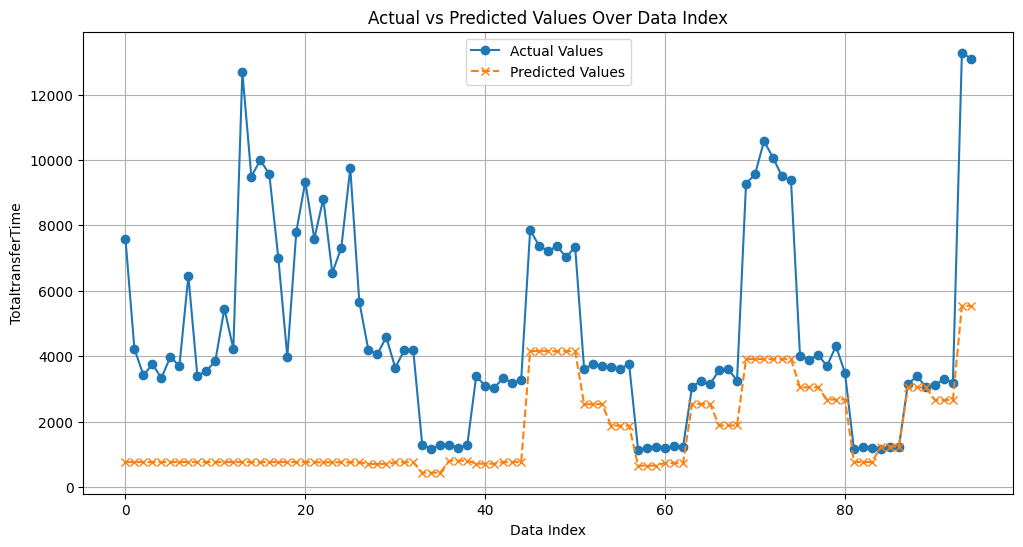

In [ ]:
# Plot actual vs predicted values by index
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(actual_values, label="Actual Values", marker="o")

# Plot predicted values
plt.plot(predictions, label="Predicted Values", marker="x", linestyle="--")

# Add labels and legend
plt.title("Actual vs Predicted Values Over Data Index")
plt.xlabel("Data Index")
plt.ylabel("TotaltransferTime")
plt.legend()
plt.grid(True)

plt.show()